In [1]:
import os 

import numpy as np

from astropy.cosmology import WMAP5 as cosmo
from astropy.table import Table
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
from astropy.utils.data import download_file

import kcorrect
import kcorrect.utils as ut

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Setup

In this notebook, we try to compare the Cosmos catalog to the resutls from the Astrodeep catalog. 

### Load Catalog

In [3]:
robel_cat_path = 'hlsp_clash_hst_rxj1347_v1_drz_petrosian_redshift_catalog.csv'
raw_robel_cat = Table.read(robel_cat_path)

In [10]:

cluster_z = 0.451
raw_robel_cat['z'][np.where(raw_robel_cat['z_quality'] == 0 )] = cluster_z

print(len(raw_robel_cat))

599


### Define Filters

Define the filter list and their corrections. For now the corrections are set to 0 because the corrected values for these filters are not used in this notebook. We use the corrected values for the UBV filters after the kcorrection.

In [11]:
filter_list = [
    'm_total_f105w',
    'm_total_f125w',
    'm_total_f140w',
    'm_total_f160w',
    'm_total_f606w',
    'm_total_f814w',
]

correction_const_dict = {
    'm_total_f105w': 0.,
    'm_total_f125w': 0.,
    'm_total_f140w': 0.,
    'm_total_f160w': 0.,
    'm_total_f606w': 0.,
    'm_total_f814w': 0.,
}



### Filter the Catalog

In [12]:
# Filter Params
# -------------
min_z = 0.0
max_z = np.inf

min_mag = 0
max_mag = np.inf


# Do the filtering
# ----------------
robel_mask = np.ones((len(raw_robel_cat))).astype(bool)
robel_mask = robel_mask & (raw_robel_cat['z'] > min_z).astype(bool)
robel_mask = robel_mask & (raw_robel_cat['z'] < max_z).astype(bool)
robel_mask = robel_mask & (~np.isnan(raw_robel_cat['z'])).astype(bool)

for f in filter_list:
    robel_mask = robel_mask & (raw_robel_cat[f] > min_mag).astype(bool)
    robel_mask = robel_mask & (raw_robel_cat[f] < max_mag).astype(bool)
    

robel_cat = raw_robel_cat[robel_mask]
print(len(robel_cat))

458


### Construct Data Structure

This section constructs the data structure that holds the information we need to compute the kcorrected catalog

In [13]:
cat = {}

mags = {}
mag_err = {}

maggies = {}
maggies_err = {}

z_best = np.array(robel_cat['z'])

num_sources = None

for f in filter_list:
    cat[f] = robel_cat[f]
    
    raw_flux = robel_cat[f] 
    raw_error = robel_cat[f.replace("mag_total", "mag_total_err")] 
    
    mags[f] = raw_flux
    mag_err[f] = raw_error
    
    maggies[f] = ut.mag2maggies(mags[f])
    maggies_err[f] = ut.invariance(maggies[f], mag_err[f])
    
    if num_sources is None:
        num_sources = len(cat[f])
    else:
        assert num_sources == len(cat[f])

### Distribution of Redshifts

single bin width= 0.009975000000000001


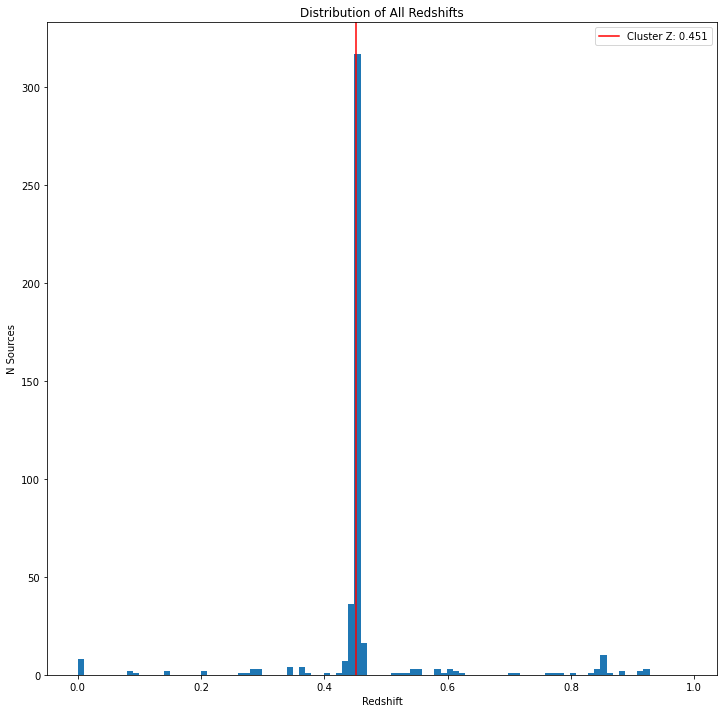

In [15]:
num_bins = 100
max_value = z_best.max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)

plt.hist(z_best, bins=[i * bin_width for i in range(num_bins)]);
plt.title("Distribution of All Redshifts")
plt.xlabel("Redshift")
plt.ylabel("N Sources")
plt.axvline(cluster_z, c='r', label='Cluster Z: {}'.format(cluster_z))
plt.legend()
plt.show()

# Load Radii

In [16]:
radii = robel_cat['r_half_light_arcsec']

single bin width= 0.009975000000000001


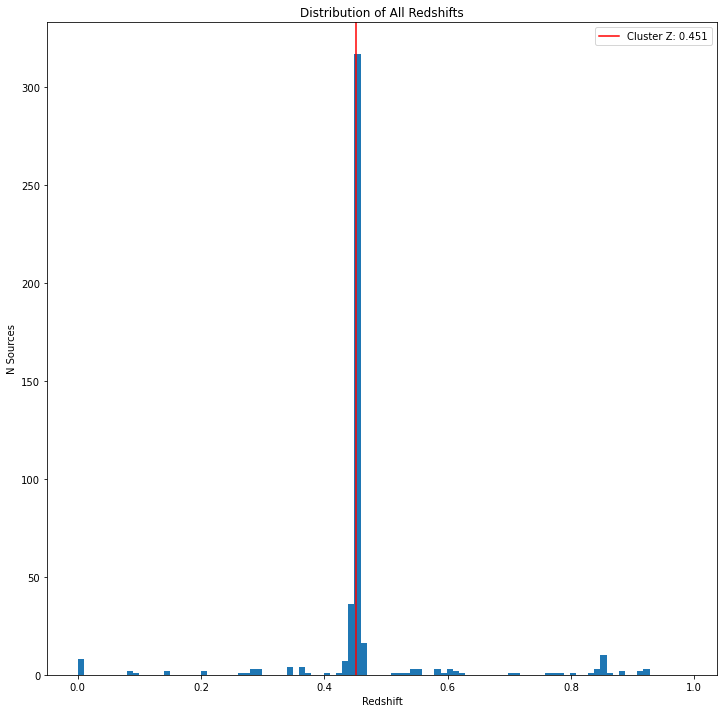

In [17]:
num_bins = 100

r_mask = np.where(~np.isnan(radii))

max_value = z_best[r_mask].max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)

plt.hist(z_best[r_mask], bins=[i * bin_width for i in range(num_bins)]);
plt.axvline(cluster_z, c='r', label='Cluster Z: {}'.format(cluster_z))
plt.title("Distribution of All Redshifts")
plt.xlabel("Redshift")
plt.ylabel("N Sources")
plt.legend()
plt.show()

# Load Input Filters

In [18]:
def print_filter_file(path):
    """Prints the contents of a kcorrect filter file"""
    with open(path) as f:
        for line in f:
            print(line.replace("\n", ""))

In [19]:
input_filter_file = os.path.abspath('hst_filters.dat')

In [20]:
print_filter_file(input_filter_file)

KCORRECT_DIR
data/filters/clash_wfc3_f105w.par
data/filters/clash_wfc3_f125w.par
data/filters/clash_wfc3_f140w.par
data/filters/clash_wfc3_f160w.par
data/filters/clash_acs_f606w.par
data/filters/clash_acs_f814w.par


In [21]:
kcorrect.load_templates()
kcorrect.load_filters(input_filter_file)

# Fit Nonnegative Sums

Fit the data and get kcorrect constants

In [22]:
kcorrect_constants = []

with ProgressBar(len(z_best), ipython_widget=True) as bar:
    
    for i in range(0, num_sources):

        all_maggies = np.array([maggies[f][i] for f in filter_list], dtype=float)
        all_maggies_err = np.array([maggies_err[f][i] for f in filter_list], dtype=float)

        z = z_best[i]

        constants = kcorrect.fit_nonneg(z, all_maggies, all_maggies_err)
        if np.any(np.isnan(np.array(constants))):
            print(constants, i)

        kcorrect_constants.append(constants)

        bar.update()

FloatProgress(value=0.0)

[0.451   nan   nan   nan   nan   nan] 260



# Reconstruct Maggies

Take the fitted constants and try to reproduce the input maggies to make sure the fit was reasonable

In [23]:
def multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=-1.0):
    re_maggies = {f: [] for f in filter_list}
    
    for constants in kcorrect_constants:
        _, *result = kcorrect.reconstruct_maggies(constants, redshift=redshift)

        for i, f in enumerate(filter_list):
            re_maggies[f].append(result[i])
            
    for i, f in enumerate(filter_list):
        re_maggies[f] = np.array(re_maggies[f])
        
    return re_maggies
    

In [24]:
def stack_filter_dict(dictionary):
    return np.stack(tuple(dictionary.values()), axis=-1)

In [25]:
re_maggies = multi_reconstruct_maggies(kcorrect_constants, filter_list)
re_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=0)

### Compare Reconstructed Maggies Vs Input Maggies

In this section, the present error between the actual data and the reconstructed maggies is computed and the average present error across filters is plotted below.

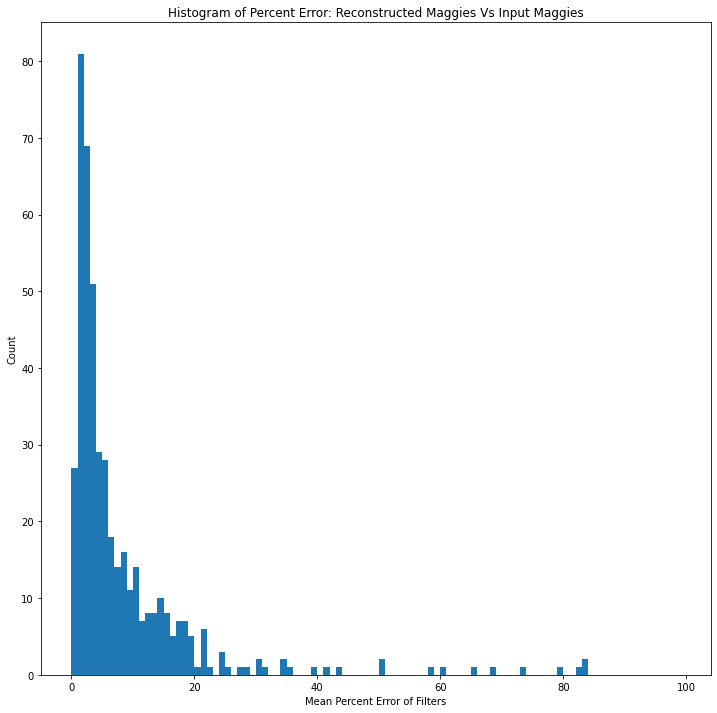

N=458


In [26]:
all_re_maggies = stack_filter_dict(re_maggies)
all_maggies = stack_filter_dict(maggies)

percent_err = 100 * abs(all_re_maggies - all_maggies) / all_maggies
percent_err = (percent_err).mean(axis=1)

bins = list(range(100))
plt.hist(percent_err, bins=bins)

#plt.xticks(bins, ["{:0.2e}".format(i) for i in bins], rotation='vertical')

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()

"""
bins = 0.1*np.array(range(100))
plt.hist(percent_err, bins=bins)

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()
"""

print("N={}".format(len(percent_err)))

# Johnson Filters

In [27]:
johnson_filter_list = ['u', 'b', 'v']

johnson_correction_const_dict = {
    'u': -0.79,
    'b': + 0.09,
    'v': -0.02
}

johnson_correction_const = np.array(list(johnson_correction_const_dict.values()))

### Load Johnson Filters

In [28]:
johnson_filter_file = os.path.abspath('johnson_ubv.dat')

In [29]:
print_filter_file(johnson_filter_file)

KCORRECT_DIR
data/filters/bessell_U.par
data/filters/bessell_B.par
data/filters/bessell_V.par


In [30]:
kcorrect.load_templates()
kcorrect.load_filters(johnson_filter_file)

### Compute Johnson Maggies 

In [31]:
johnson_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, johnson_filter_list, redshift=0)

# Compute Vega Mag 

In [32]:
m_vega_mags = {}
M_vega_mags = {}

# Johnson filters
for i, f in enumerate(johnson_filter_list):
    m_vega_mags[f] = -2.5 * np.log10(johnson_maggies_z0[f]) + johnson_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value

# Original filters
for i, f in enumerate(filter_list):
    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value


# Compute Surface Brightnesses

In [33]:
m_b = m_vega_mags['b']

In [34]:
r_half_light_arcsec = radii 

In [35]:
surface_brightness = m_b + 5 * np.log10(r_half_light_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1 + z_best)
surface_brightness[np.where(np.isnan(surface_brightness))] = np.nan

# Make Catalog

In [36]:
# Define Column Names
# -------------------

col_names = [
    'id', 'ra', 'dec',
    'z', 'z_quality',
    'surface_brightness',
    'r_half_light_arcsec',
    
] 

col_names += ["m_{}".format(f.replace('MAG_','')) for f in m_vega_mags.keys()] 
col_names += ["M_{}".format(f.replace('MAG_','')) for f in M_vega_mags.keys()]
col_names += ["kcorrect_constant_{}".format(i) for i in range(len(kcorrect_constants[0]))]

# Construct the rows of the catalog
# ----------------------------------

final_catalog_rows = [
    robel_cat['label'],
    robel_cat['ra'],
    robel_cat['dec'],
    np.array(robel_cat['z']),
    np.array(robel_cat['z_quality']),
] 
final_catalog_rows += [surface_brightness]
final_catalog_rows += [r_half_light_arcsec]
final_catalog_rows += list(m_vega_mags.values()) 
final_catalog_rows += list(M_vega_mags.values()) 
final_catalog_rows += list(map(list, zip(*kcorrect_constants)))    

# Make the catalog
# ----------------

final_catalog = Table(data=final_catalog_rows, names=col_names)

# Filter Catalog
# --------------

# Mask out sources with missing values
# r80 is a good indicator that things failed so we use that column to mask
catalog_mask =  (
    np.invert(np.isnan(surface_brightness)).astype(bool) & 
    np.invert(np.isnan(radii)).astype(bool) #&
    #(final_catalog['m_subaru_i'] < 22.5).astype(bool) # & 
    #np.invert(final_catalog['z'] >= 3) & 
    #(final_catalog['z'] > 0.25).astype(bool)&
    #(final_catalog['z'] < 0.35).astype(bool)
)

final_catalog = final_catalog[catalog_mask]

final_catalog.sort(keys="r_half_light_arcsec")
print(len(final_catalog))

457


In [37]:
final_catalog

id,ra,dec,z,z_quality,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,m_m_total_f105w,m_m_total_f125w,m_m_total_f140w,m_m_total_f160w,m_m_total_f606w,m_m_total_f814w,M_u,M_b,M_v,M_m_total_f105w,M_m_total_f125w,M_m_total_f140w,M_m_total_f160w,M_m_total_f606w,M_m_total_f814w,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32
69,206.87483078498346,-11.763936976601668,0.451,0.0,20.841861249797425,0.023755751150230632,28.805912,28.584242,27.611647,25.920498,25.653782,25.520506,25.382938,27.375746,26.564003,-13.197236931969641,-13.418907082726477,-14.391502297570227,-16.082651055504797,-16.349367058922766,-16.48264304464054,-16.62021056478214,-14.627403176476477,-15.43914595906925,0.451,1.9996065e-09,2.647055e-13,6.057811e-19,1.4576043e-09,6.451995e-18
584,206.89177883023643,-11.729125896222296,0.451,0.0,21.042854733087733,0.04649729945989312,26.558407,27.32694,27.06448,25.725182,25.44091,25.297836,25.154236,26.89723,26.372192,-15.444742119957922,-14.676208413292883,-14.938669121911047,-16.277967370202063,-16.562238610436438,-16.70531264608097,-16.848913109948157,-15.105918801476477,-15.630956566979407,0.451,3.0515428e-09,5.0578534e-12,3.5e-44,3e-44,4.8e-44
542,206.85874989770593,-11.749112414376194,0.451,0.0,23.420090091128053,0.0865583116623346,27.92347,28.35477,27.637497,25.795464,25.484074,25.333042,25.18288,27.37616,26.527681,-14.079679406334876,-13.648378289391516,-14.36565200154972,-16.207685387780188,-16.51907531087589,-16.670106805016516,-16.82026854818058,-14.626989281823157,-15.475467599083899,0.451,3.0104355e-09,1.3006835e-12,6.4e-44,7.8e-44,5.38e-43
67,206.87383485687232,-11.764207777096164,0.451,0.0,22.357238756919706,0.10298059611922637,27.00806,26.914686,26.178505,25.055159,24.89365,24.806293,24.70573,26.037958,25.476273,-14.995088494469641,-15.088462746788977,-15.82464400594425,-16.947990334679602,-17.109498894860266,-17.19685546224308,-17.297418511559485,-15.965190804650305,-16.526876366784094,0.451,1.7782755e-09,5.532924e-16,4.223882e-21,7.400677e-09,2.2905887e-10
32,206.8910053665126,-11.768902303432215,0.451,0.0,22.18402815895573,0.1036307261452316,26.540829,26.72781,26.232145,25.210804,25.007496,24.903898,24.794323,26.122162,25.626871,-15.462320244957922,-15.275339043786047,-15.771003640343665,-16.792344964196204,-16.995653069664954,-17.099250710656165,-17.20882598226261,-15.880987084557532,-16.376277840783118,0.451,3.1482132e-09,2.551911e-31,4.2172362e-20,1.1585674e-09,5.669937e-10
275,206.89948808458803,-11.748138077097469,0.451,0.0,21.906390341112413,0.10675135027005664,25.643953,26.385748,26.150257,24.958187,24.690228,24.5537,24.415705,26.007002,25.551683,-16.35919562642765,-15.617401040246008,-15.852891839196204,-17.044961846520422,-17.312921441246985,-17.449449456383704,-17.587444222619055,-15.996147072960852,-16.451465523888587,0.451,5.8727068e-09,1.091074e-11,1.653374e-25,1.0029457e-15,1.0473937e-10
66,206.88466086866978,-11.764207948554208,0.00052677285613556,2.0,22.073654644768812,0.11037907581516573,24.092072,24.866058,24.672546,23.725222,23.507347,23.388954,23.264303,24.553879,24.2307,-2.6693691527764756,-1.8953823363702256,-2.0888942992608506,-3.0362190520684678,-3.254093579046007,-3.3724865233819443,-3.4971374785821396,-2.207561901799913,-2.5307411467950303,0.00052677287,1.3904926e-08,4.8291645e-11,9.793206e-12,9.306952e-09,3.3595924e-28
197,206.86697470168028,-11.754024124314633,0.451,0.0,22.063853869314595,0.11390278055611402,25.725796,26.402407,26.090809,24.801476,24.527952,24.390251,24.251324,25.934845,25.40866,-16.277353203942297,-15.600742257287024,-15.912340081383704,-17.201673424889563,-17.47519675557804,-17.612897790123938,-17.751825249840735,-16.068303979088782,-16.5944880611

# LCBG Catalog

In [38]:
M_B = np.array(final_catalog['M_b'])
M_V = np.array(final_catalog['M_v'])
B_minus_V = M_B-M_V
sb = final_catalog['surface_brightness']

final_cat_z = final_catalog['z']
#final_cat_zuse = final_catalog['zuse']

r_half_light_arcsec_list = final_catalog['r_half_light_arcsec']

# Filter LCBG
# -----------

lcbg_mask = (
    (B_minus_V < 0.5).astype(bool) & 
    (sb < 21).astype(bool) & 
    (M_B < -18.5).astype(bool) #& 
    
    #(final_cat_z < 0.5).astype(bool)&
    #(final_cat_z > 0.1).astype(bool)&
    
    #(r_half_light_arcsec_list < 0.5).astype(bool) & # Guzman et al. (1997) and Phillips et al. (1997)
    #(0.2 < r_half_light_arcsec_list).astype(bool)   # Remove star like objects
)

lcbg_catalog = final_catalog[lcbg_mask]
len(lcbg_catalog)

10

In [39]:
lcbg_catalog

id,ra,dec,z,z_quality,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,m_m_total_f105w,m_m_total_f125w,m_m_total_f140w,m_m_total_f160w,m_m_total_f606w,m_m_total_f814w,M_u,M_b,M_v,M_m_total_f105w,M_m_total_f125w,M_m_total_f140w,M_m_total_f160w,M_m_total_f606w,M_m_total_f814w,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32
101,206.86909522893725,-11.76027146263395,0.451,0.0,14.176968833048784,0.127230446089221,17.997246,18.275238,17.921453,17.350906,17.229052,17.166542,17.097313,17.864113,17.55985,-24.005903161217688,-23.727910912682532,-24.08169547383976,-24.652242577721594,-24.774097359826087,-24.83660689656925,-24.905836022545813,-24.139036095788,-24.443298257042883,0.451,3.0338342e-06,1.3461129e-13,1.5028988e-18,9.93248e-11,1.5856011e-06
214,206.86400561742892,-11.752344768569484,0.451,0.0,15.727094226623072,0.12872574514903296,18.9472,19.799992,19.72329,18.804462,18.555807,18.423588,18.289076,19.610998,19.351631,-23.055948174645422,-22.20315734212589,-22.279859460045813,-23.19868651693058,-23.447341836144446,-23.57956115071964,-23.714073098351477,-22.392150796105383,-22.651517785241126,0.451,1.6699053e-06,5.713508e-09,5.3e-44,1.7752e-41,1.19144e-40
120,206.89419568978084,-11.75933276159126,0.451,0.0,18.50289901679436,0.12901180236047524,22.284767,22.570976,22.22335,21.673378,21.556568,21.49661,21.429901,22.167725,21.872562,-19.718381798913,-19.432172692467688,-19.779798424889563,-20.32977095906925,-20.446580804039954,-20.506538308312415,-20.573247826745032,-19.835424340416907,-20.13058654134464,0.451,5.4903726e-08,3.6225116e-12,2.279612e-16,2.8605091e-12,3.017184e-08
378,206.88478987412427,-11.737882948638198,0.451,0.0,18.796278798649098,0.1434446889377911,21.870085,22.63408,22.415009,21.221827,20.951946,20.814285,20.675295,22.27073,21.822811,-20.133064187218665,-19.369068062951087,-19.588140404870032,-20.78132239644718,-21.051202691246985,-21.188863671471594,-21.327854073693274,-19.7324198848505,-20.180337823082922,0.451,1.8534679e-07,3.6344597e-10,1.3734324e-25,9.608292e-15,2.1810742e-09
552,206.87497899716305,-11.743046703872366,0.4595,2.0,20.984094569613806,0.2724824964993065,22.980122,23.453993,23.18112,22.57782,22.430641,22.351973,22.266804,23.116322,22.846504,-19.07161843798822,-18.59774720690912,-18.870620131713807,-19.4739202263183,-19.621098876220643,-19.699767470580994,-19.78493630908197,-18.935418486816346,-19.205235839111268,0.4595,3.044461e-08,5.4579556e-11,6.443834e-12,7.021688e-12,9.82267e-09
489,206.88097236924307,-11.755360713918083,0.43457316175904137,2.0,20.743201894320393,0.3633576715343158,21.642387,22.513308,22.514103,22.07701,21.920364,21.821884,21.715149,22.444012,22.436234,-20.264410696006067,-19.393490514731653,-19.39269515035177,-19.82978888509298,-19.986433706259973,-20.084913930869348,-20.191649160361536,-19.462786397910364,-19.470564565634973,0.43457317,5.7377342e-08,4.754449e-10,7.181468e-17,3.161604e-08,1.5378919e-10
345,206.8993032499707,-11.740753365337413,0.451,0.0,20.94894388092762,0.41707141428286687,21.635832,22.469116,22.533033,23.039923,23.25174,23.352491,23.46782,22.51911,22.84671,-20.367317116906165,-19.534032738854407,-19.470115578820227,-18.96322623555851,-18.751409447838782,-18.650657571007727,-18.53532973592472,-19.48403922383976,-19.156438744713782,0.451,1.4e-44,4.240736e-10,8.556029e-39,2.5e-44,7.5081905e-09
64,206.88060342062627,-11.764117654356395,0.4329742919415245,2.0,19.740598469312033,0.4267843568713848,20.78878,21.15649,20.869278,20.416145,20.326473,20.275017,20.215546,20.79582,20.605886,-21.10846112714208,-20.740751013616688,-21.02796338544286,-21.48109601483739,-21.570768103460438,-21.622224554876453,-21.681695685247547,-21.101421103338367,-21.291354880

# Blue Catalog

In [40]:
# Filter Blue
# -----------

blue_mask = (
    (B_minus_V < 0.6).astype(bool) & 
    (M_B < -18.5).astype(bool) & 
    
    #(final_cat_z < 0.5).astype(bool)&
    #(final_cat_z > 0.1).astype(bool)&
    
    #(r_half_light_arcsec_list < 0.5).astype(bool) & # Guzman et al. (1997) and Phillips et al. (1997)
    (0.2 < r_half_light_arcsec_list).astype(bool)   # Remove star like objects
)

blue_catalog = final_catalog[blue_mask]
len(blue_catalog)

34

# Save Catalog

In [41]:
output_catalog_filename = robel_cat_path.replace('catalog.csv', 'kcorrected_catalog.csv')
output_lcbg_catalog_filename = robel_cat_path.replace('catalog.csv', 'kcorrected_lcbg_catalog.csv')
output_blue_catalog_filename = robel_cat_path.replace('catalog.csv', 'kcorrected_blue_catalog.csv')
print(output_catalog_filename)
print(output_lcbg_catalog_filename)
print(output_blue_catalog_filename)

hlsp_clash_hst_rxj1347_v1_drz_petrosian_redshift_kcorrected_catalog.csv
hlsp_clash_hst_rxj1347_v1_drz_petrosian_redshift_kcorrected_lcbg_catalog.csv
hlsp_clash_hst_rxj1347_v1_drz_petrosian_redshift_kcorrected_blue_catalog.csv


In [42]:
final_catalog.write(output_catalog_filename, format="ascii.csv", overwrite=True)
lcbg_catalog.write(output_lcbg_catalog_filename, format="ascii.csv", overwrite=True)
blue_catalog.write(output_blue_catalog_filename, format="ascii.csv", overwrite=True)

# Plot Setup

In [43]:
def z_mask(zlist, zmin=0, zmax=np.inf):
    zlist = np.array(zlist)
    return (zlist > zmin).astype(bool) & (zlist < zmax).astype(bool)

z_bins = [
    [0.1, 0.35],
    [0.35, 0.55],
    [0.55, 0.75],
    [0.75, 1.0]
]

# Plot B-V vs M<sub>b</sub> 

#### All data points

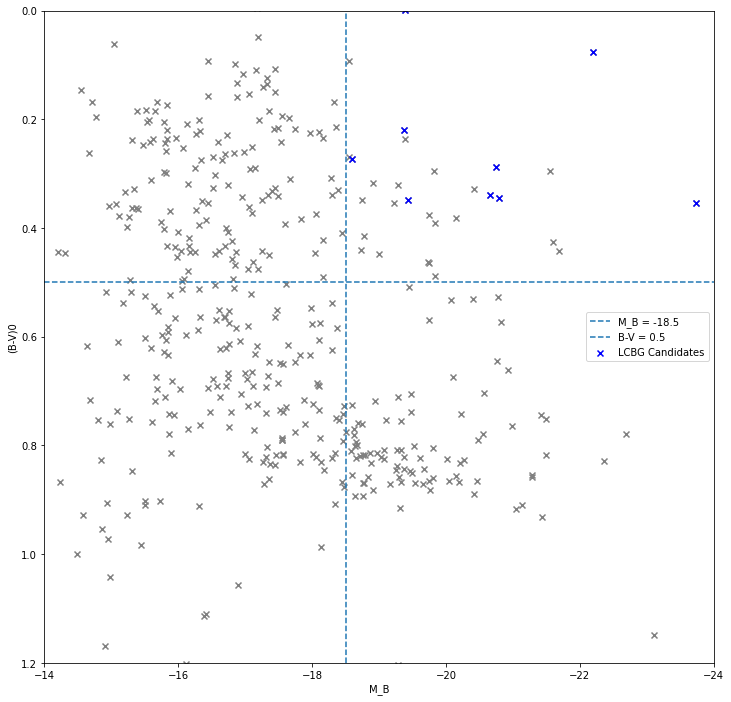

In [44]:
plt.scatter(M_B, B_minus_V, c='gray', marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(0.5, label='B-V = 0.5', linestyle='--')

plt.scatter(M_B[lcbg_mask], B_minus_V[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel('M_B')
plt.ylabel('(B-V)0')

plt.xlim(-14, -24)
plt.ylim(1.2, -0)

plt.legend()


# Plot Surface Brightness Vs M_B

### All data points

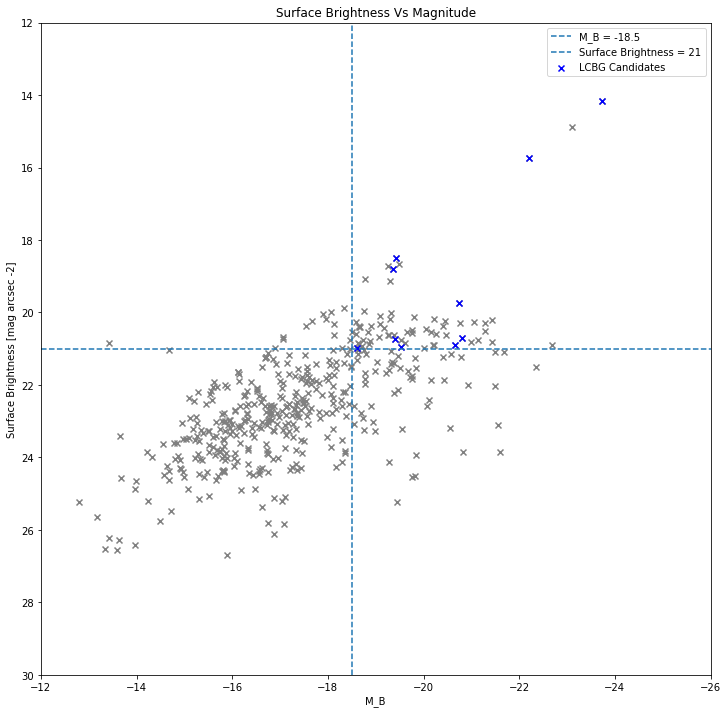

In [45]:
xlim = (-12, -26)
ylim = (30, 12)

# Plot all data and lcbgs
# -----------------------
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel("M_B")
plt.ylabel("Surface Brightness [mag arcsec -2]")
plt.title("Surface Brightness Vs Magnitude")

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.legend()

plt.show()




# Plot Surface Brightness Vs B-V

### All data points

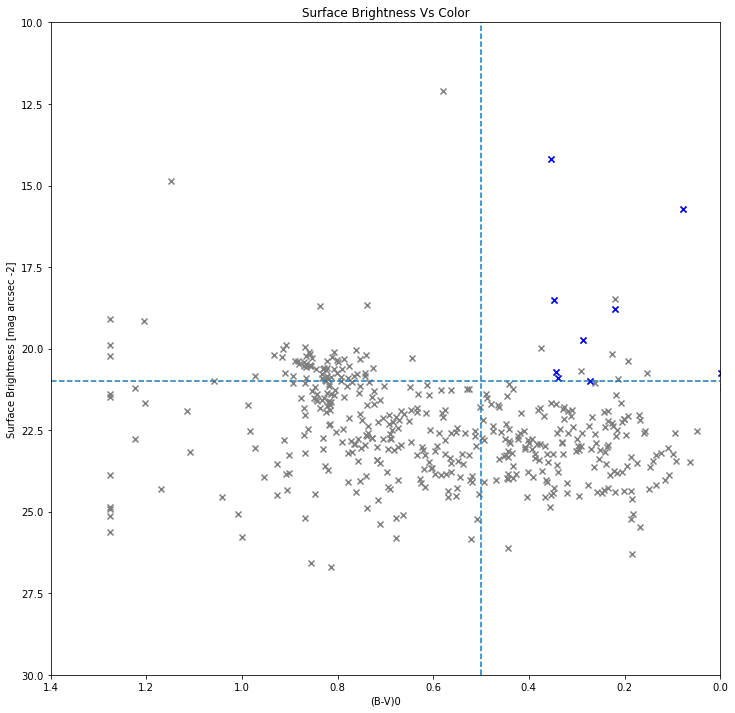

In [46]:
xlim = (1.4, 0.)
ylim = (30, 10)

# Plot all data and lcbgs
# -----------------------

plt.scatter(B_minus_V, sb, color="gray", marker='x')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(B_minus_V[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color")

plt.xlim(xlim)
plt.ylim(ylim)

#plt.legend()
plt.show()

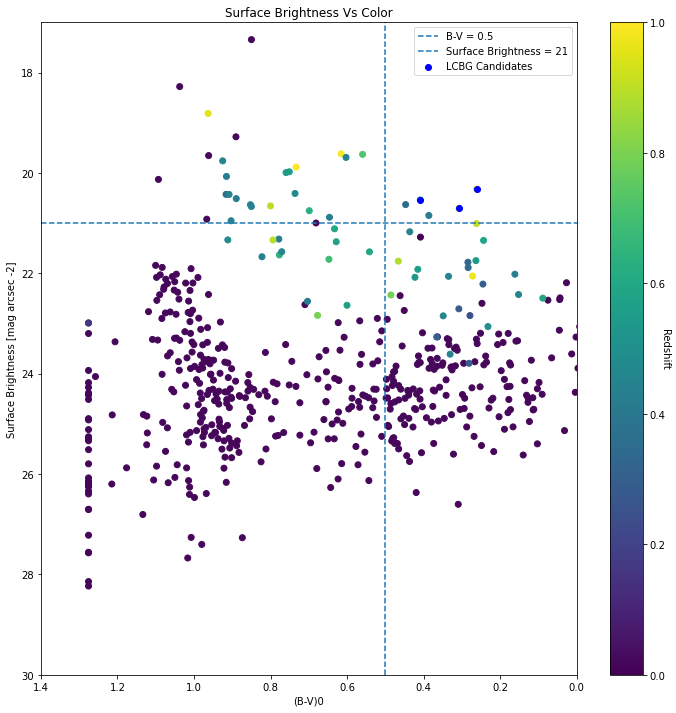

In [41]:
xlim = (1.4, 0.)
ylim = (30, 17)

# Plot all data and lcbgs
# -----------------------

plt.scatter(B_minus_V, sb, c=final_cat_z, marker='o')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(B_minus_V[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='o')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color")

cbar = plt.colorbar()
cbar.set_label('Redshift', rotation=270)

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()
plt.show()